# Bitcoin Data Analysis

## Time Series Forcasting

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss

## Overview

we are doing predictions for Bitcoin's future price, we are performing a 30-day forecasting period for the bitcoins price based on the past year's price fluctuations. each time that this file loads it will automatically download the latest Bitcoin data from Yahoo financial API which we can easily access with "yfinance" package in python. keeping that in mind that based on the changes in the Bitcoin price our models may or may not need parameter adjustments to get the most accurate results.

In [107]:
# KPSS test Function from statsmodels package
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [108]:
bitcoin_data

,Price
Date,
2022-08-21,21534.121094
2022-08-22,21398.908203
2022-08-23,21528.087891
2022-08-24,21395.019531
2022-08-25,21600.904297
...,...
2023-08-14,29408.443359
2023-08-15,29170.347656
2023-08-16,28701.779297


We begin with importing the data from Yahoo Finance and plotting the price of Bitcoin in the past year which started at around 21000 and now it is about 26000 with a gradual increase over the year. the data is not seasonal but it looks very cyclical and there is a trend.

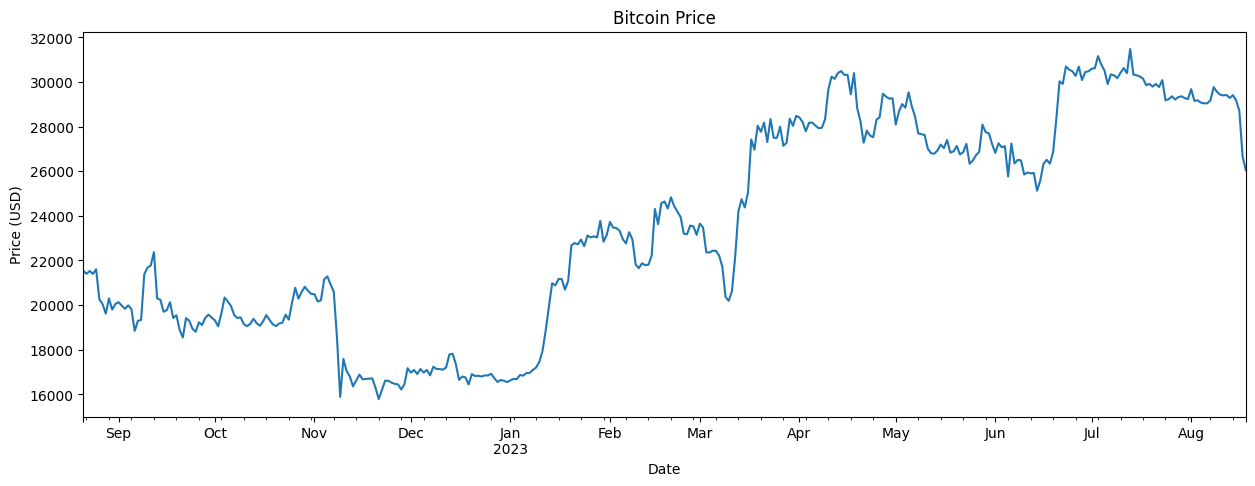

In [109]:
from datetime import timedelta

bitcoin_data = yf.download('BTC-USD',
                           start=datetime.now()- timedelta(days=365),
                           end=datetime.now(),
                           progress=False)
bitcoin_data.reset_index(inplace=True)

bitcoin_data = bitcoin_data[['Date', 'Close']]
bitcoin_data.columns = ['Date', 'Price']
bitcoin_data.set_index('Date', inplace=True)

bitcoin_data['Price'].plot(figsize=(15, 5))
plt.title('Bitcoin Price')
plt.ylabel('Price (USD)')
plt.show()

## ARIMA Model



to check the data for cyclicality and the trend, we plot ACF and PACF  to analyze our data visually we can see that the ACF plot shows that the data is highly cyclical as we assumed earlier. Hence it means that we need to do differencing on our data to make it stationary for building an ARIMA model.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


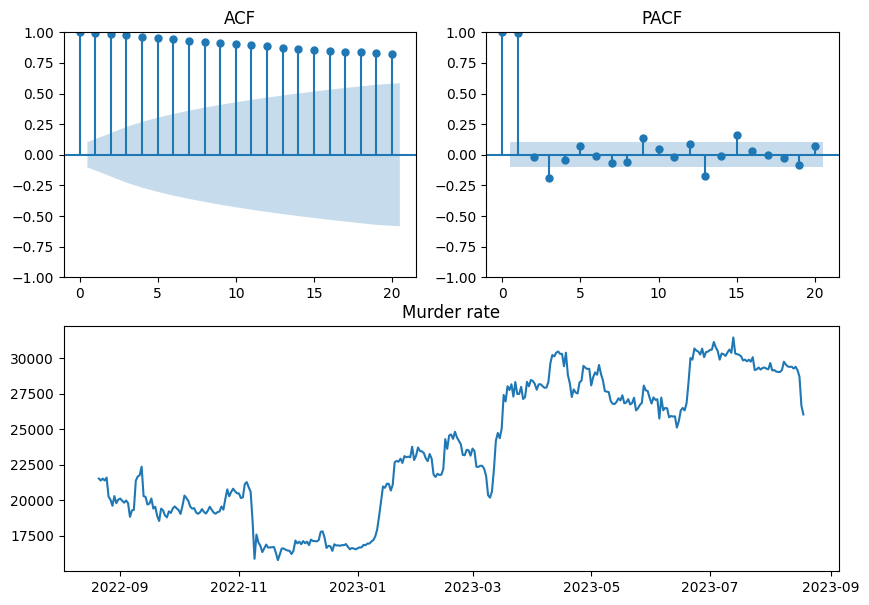

In [110]:
plt.figure(figsize=(10,7))
ax1 = plt.subplot(212)
ax1.plot(bitcoin_data)
ax1.set_title('Murder rate')
ax2 = plt.subplot(221)
ax2=plot_acf(bitcoin_data, lags=20, ax=plt.gca(), title='ACF')
ax3 = plt.subplot(222)
ax3=plot_pacf(bitcoin_data, lags=20, ax=plt.gca(), title='PACF')

we can say by looking at the data that data is not stationary but we run the KPSS test to see for sure that the test statistic is higher than critical value which we reject the $H_0$.

In [111]:
kpss_test(bitcoin_data)

Results of KPSS Test:
Test Statistic            2.550118
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


so the measure we take next is to take differencing of our current data to make it stationary for the ARIMA model. and the we plot ACF and PACF to see the correlations between lags. and we can see the data is stationary and there is no correlation between the variables. 

In [112]:
bitcoin_data_diff=bitcoin_data.diff().dropna()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


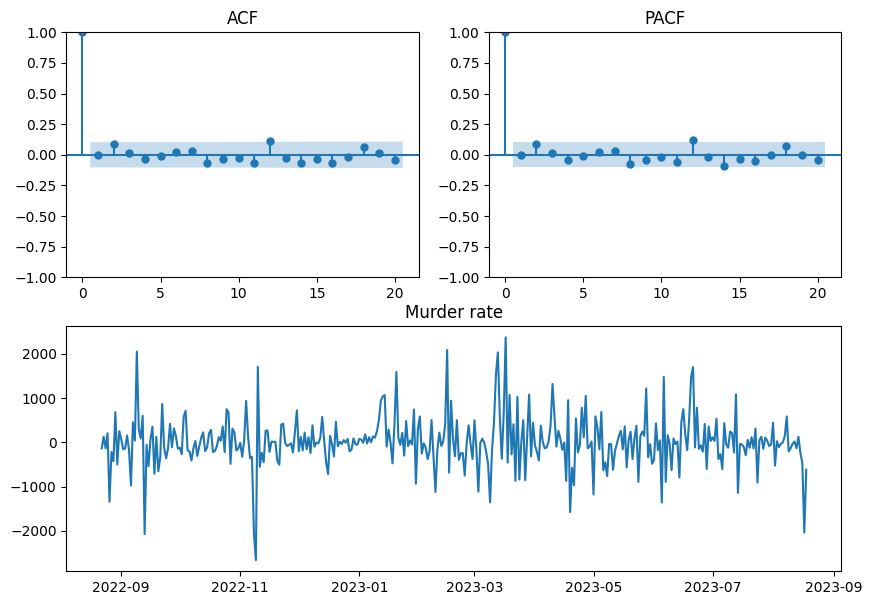

In [113]:
plt.figure(figsize=(10,7))
ax1 = plt.subplot(212)
ax1.plot(bitcoin_data_diff)
ax1.set_title('Murder rate')
ax2 = plt.subplot(221)
ax2=plot_acf(bitcoin_data_diff, lags=20, ax=plt.gca(), title='ACF')
ax3 = plt.subplot(222)
ax3=plot_pacf(bitcoin_data_diff, lags=20, ax=plt.gca(), title='PACF')

we again will perform KPSS test to the test statistic which is lower than 10% critical value and the p-value is high so we retain the $H_0$ and accept that data is staitionary.

In [114]:
kpss_test(bitcoin_data_diff)

Results of KPSS Test:
Test Statistic           0.104941
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


next, we want to do the ARIMA Model, and because there are no correlations between values using both ACF and PACF after first differencing choose P D Q as respectively 1,1,0 and build the model. and do a forecasting of 30 dates after today. we print the actual forecasted values here to see and also make a chart to visualize the forecasted values.

            predicted_mean
2023-08-19    26055.138663
2023-08-20    26055.087998
2023-08-21    26055.088458
2023-08-22    26055.088453
2023-08-23    26055.088454
2023-08-24    26055.088454
2023-08-25    26055.088454
2023-08-26    26055.088454
2023-08-27    26055.088454
2023-08-28    26055.088454
2023-08-29    26055.088454
2023-08-30    26055.088454
2023-08-31    26055.088454
2023-09-01    26055.088454
2023-09-02    26055.088454
2023-09-03    26055.088454
2023-09-04    26055.088454
2023-09-05    26055.088454
2023-09-06    26055.088454
2023-09-07    26055.088454
2023-09-08    26055.088454
2023-09-09    26055.088454
2023-09-10    26055.088454
2023-09-11    26055.088454
2023-09-12    26055.088454
2023-09-13    26055.088454
2023-09-14    26055.088454
2023-09-15    26055.088454
2023-09-16    26055.088454
2023-09-17    26055.088454


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


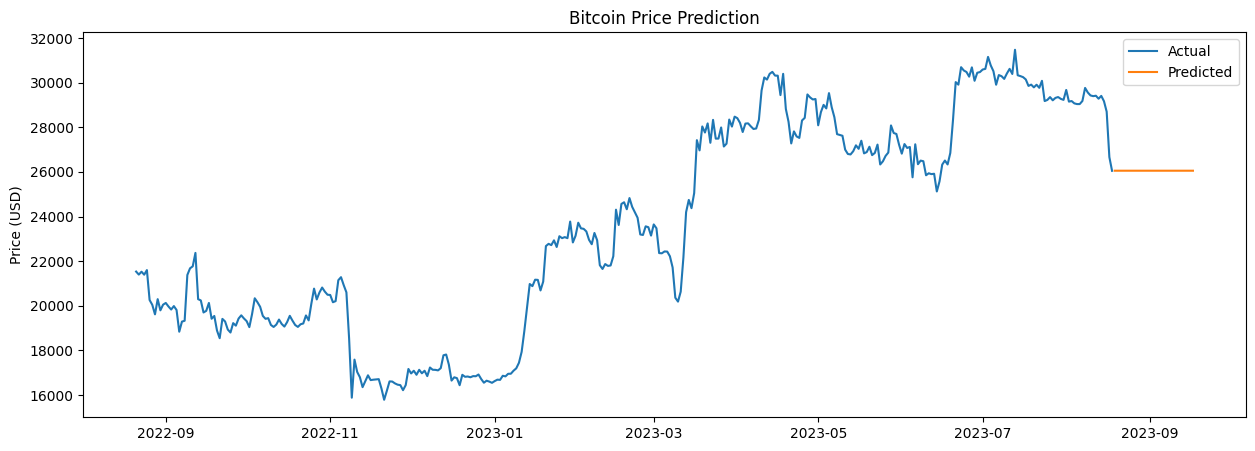

In [115]:

# Perform time series analysis using ARIMA model
model = ARIMA(bitcoin_data,
              order=(1, 1, 0))
model_fit = model.fit()

# Make future predictions
future_predictions = pd.DataFrame(model_fit.forecast(steps=30))
print(future_predictions)

# Plot the future predictions
plt.figure(figsize=(15,5))
plt.plot(bitcoin_data, label='Actual')
#plt.plot(model_fit.fittedvalues)
plt.plot(future_predictions, label='Predicted')
plt.title('Bitcoin Price Prediction')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

and for the model summary we have sigma 2 as the coefficient which is significant and the auto regression lag 1 which is not significant.

In [116]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2817.965
Date:                Mon, 21 Aug 2023   AIC                           5639.931
Time:                        14:25:05   BIC                           5647.714
Sample:                    08-21-2022   HQIC                          5643.025
                         - 08-18-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0091      0.035     -0.257      0.797      -0.078       0.060
sigma2       3.39e+05   1.57e+04     21.594      0.000    3.08e+05     3.7e+05
Ljung-Box (L1) (Q):                   0.01   Jarque-

the value of root mean squer error is also as follows:

In [117]:
print("RMSE for ARIMA Model: ", np.sqrt((model_fit.resid**2).mean()))

RMSE for ARIMA Model:  1270.666433436001


Text(0.5, 1.0, '30 day pridictions')

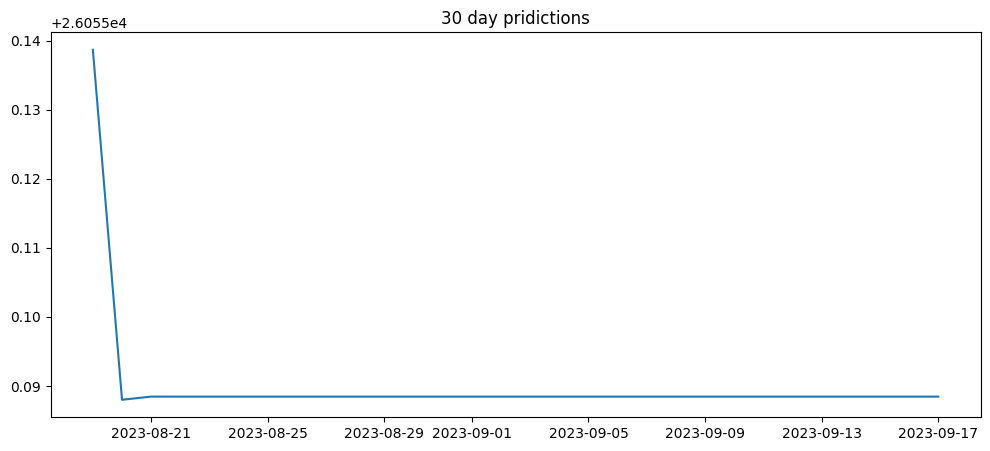

In [118]:
plt.figure(figsize=(12,5))
plt.plot(future_predictions)
plt.title('30 day pridictions')

now we want to check and see which model parameters does Auto Arima model from the package "pmdarima" chooses for an optimal model.

In [119]:

from pmdarima.arima import auto_arima

AAmodel=auto_arima(bitcoin_data,
                   start_P=0,
                   start_q=0,
                   max_d=2)
print(AAmodel.arparams)

<bound method ARIMA.arparams of ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>


The model auto arima chose is the order (0,1,0) which did not consider lag 1 autoregression as significant which was true and we can see the value of AIC is slightly lower than our model. The value of RMSE is also the same as our model.

In [120]:
print(AAmodel.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2817.984
Date:                Mon, 21 Aug 2023   AIC                           5637.968
Time:                        14:25:06   BIC                           5641.860
Sample:                    08-21-2022   HQIC                          5639.515
                         - 08-18-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.372e+05   1.46e+04     23.131      0.000    3.09e+05    3.66e+05
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               227.04
Prob(Q):                              0.91   Pr

In [121]:
print("RMSE for ARIMA Model: ", np.sqrt((AAmodel.resid()**2).mean()))

RMSE for ARIMA Model:  1270.6800427498222


## Test for Seasonality

We already know that our there is no seasonality in Bitcoin's price change in the past year but we are seeing a repetitive pattern in our data which brings us to the point that we wanted to try and see what is the pattern in our data. So we performed an exponential smoothing model using additive trend and seasonality and let the algorithm estimate the parameters, doing seasonal periods of less than 150 days. we stored the RMSE for each model for later comparison and see which seasonal period gives us the lowest RMSE in term of seasonality. and we plot and print the result to see the lowest value which is 116.

In [122]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL

rmse=[]
aic=[]
for k in range(3,150):
    modelexp=ExponentialSmoothing(bitcoin_data,
                              trend='add',
                              seasonal='add',
                              damped_trend=True,
                              initialization_method='estimated',
                              seasonal_periods=k).fit()

    rmse.append(np.sqrt((modelexp.resid**2).mean()))

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-pac

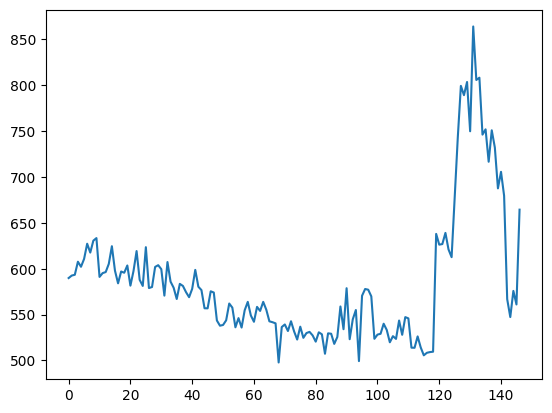

Optimal Seasonal Period:  68


In [123]:
plt.plot(rmse)
plt.show()
print('Optimal Seasonal Period: ',np.argmin(rmse))

We will run the STL model and plot the model to see the seasonality in the data, which we can see with a gradual decrease and increase in the variance there can be similarity in patterns each 116 days!

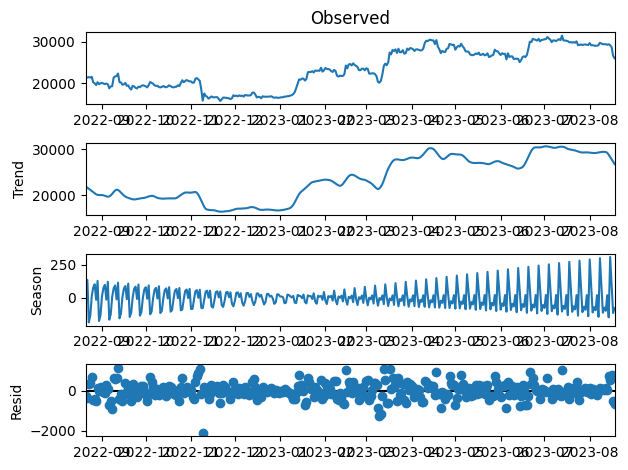

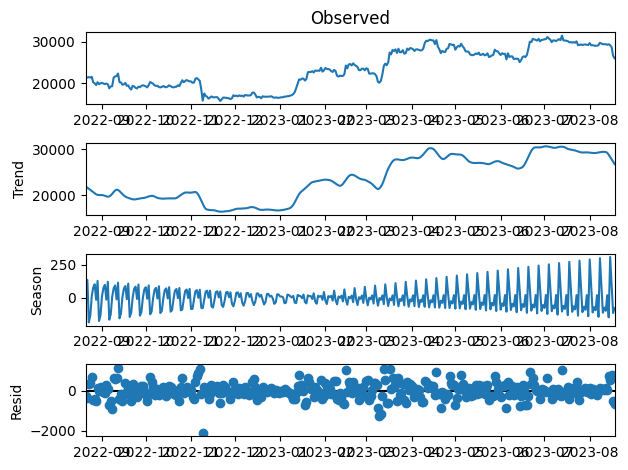

In [124]:
stl_model = STL(bitcoin_data,seasonal=115).fit()

stl_model.plot()

# Exponential Smoothing and Holt's Method:

after we understood that there is no seasonality and we have a trend we perform an exponential smoothing model with a damped trend and let the model decide the parameter values we forecast for the next 31 days which resulted in a downward trend which if we visually compare the trend with the past we can see a similar downward pattern in May 2023 up to July.

2023-08-19    25996.669530
2023-08-20    25926.890601
2023-08-21    25857.809461
2023-08-22    25789.419133
2023-08-23    25721.712708
2023-08-24    25654.683347
2023-08-25    25588.324280
2023-08-26    25522.628803
2023-08-27    25457.590282
2023-08-28    25393.202145
2023-08-29    25329.457890
2023-08-30    25266.351077
2023-08-31    25203.875333
2023-09-01    25142.024346
2023-09-02    25080.791868
2023-09-03    25020.171716
2023-09-04    24960.157765
2023-09-05    24900.743954
2023-09-06    24841.924280
2023-09-07    24783.692804
2023-09-08    24726.043642
2023-09-09    24668.970972
2023-09-10    24612.469029
2023-09-11    24556.532104
2023-09-12    24501.154550
2023-09-13    24446.330770
2023-09-14    24392.055229
2023-09-15    24338.322443
2023-09-16    24285.126985
2023-09-17    24232.463481
2023-09-18    24180.326613
Freq: D, dtype: float64


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


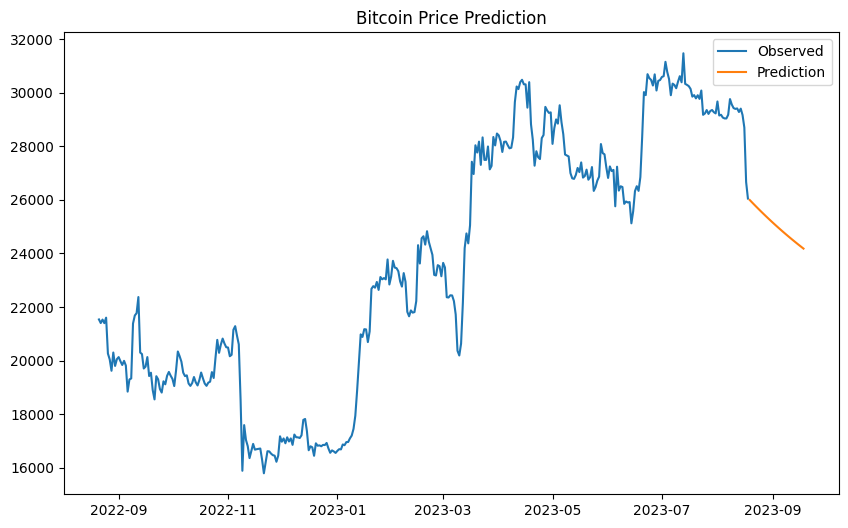

In [125]:
modelexp=ExponentialSmoothing(bitcoin_data,
                              trend='add',
                              damped_trend=True,
                              initialization_method='estimated').fit()

modelexp.summary()

expforecast=modelexp.forecast(steps=31)
print(expforecast)
plt.figure(figsize=(10,6))
plt.plot(bitcoin_data, label='Observed')
plt.plot(expforecast, label='Prediction')
plt.title('Bitcoin Price Prediction')
plt.legend()

the results for this model are very promising which we can see next when we calculated the RMSE for this model it is the best performance among all the models we already tried. and we also can see a significant drop in values of AIC, BIC and AICc.

In [126]:
print(modelexp.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  363
Model:             ExponentialSmoothing   SSE                      123887343.190
Optimized:                         True   AIC                           4634.794
Trend:                         Additive   BIC                           4654.266
Seasonal:                          None   AICC                          4635.110
Seasonal Periods:                  None   Date:                 Mon, 21 Aug 2023
Box-Cox:                          False   Time:                         14:25:16
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9714286                alpha                 True
smoothing_trend            0.02312

In [127]:
print('RMSE for this model is: ', np.sqrt((modelexp.resid**2).mean()))

RMSE for this model is:  584.1981229035348


## Exponential Smoothing

we do this model once more using "heuristic" initialization method and smoothing level and smoothing trend values of 0.1 to get a smoother model fit to see the trend. As a remark we expect to see a possible higher RMSE because it is not the optimal model.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2023-08-19    28233.198357
2023-08-20    28150.505068
2023-08-21    28068.638712
2023-08-22    27987.591019
2023-08-23    27907.353804
2023-08-24    27827.918961
2023-08-25    27749.278466
2023-08-26    27671.424376
2023-08-27    27594.348827
2023-08-28    27518.044033
2023-08-29    27442.502288
2023-08-30    27367.715960
2023-08-31    27293.677495
2023-09-01    27220.379415
2023-09-02    27147.814315
2023-09-03    27075.974867
2023-09-04    27004.853813
2023-09-05    26934.443969
2023-09-06    26864.738224
2023-09-07    26795.729537
2023-09-08    26727.410936
2023-09-09    26659.775522
2023-09-10    26592.816461
2023-09-11    26526.526991
2023-09-12    26460.900416
2023-09-13    26395.930107
2023-09-14    26331.609500
2023-09-15    26267.932100
2023-09-16    26204.891474
2023-09-17    26142.481254
2023-09-18    26080.695136
Freq: D, dtype: float64
RMSE for this model is:  1312.5987110865674


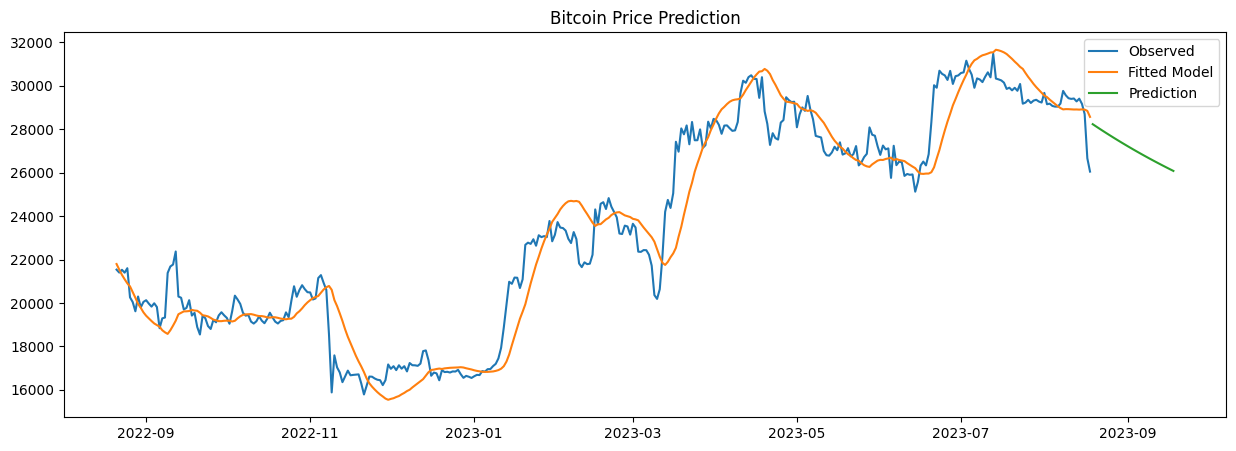

In [128]:
modelexp=ExponentialSmoothing(bitcoin_data,
                              trend='add',
                              damped_trend=True,
                              initialization_method='heuristic').fit(smoothing_level=0.1,
                                                                     smoothing_trend=0.1)

modelexp.summary()

expforecast=modelexp.forecast(steps=31)
print(expforecast)

plt.figure(figsize=(15,5))
plt.plot(bitcoin_data, label='Observed')
plt.plot(modelexp.fittedvalues, label='Fitted Model')
plt.plot(expforecast, label='Prediction')
plt.title('Bitcoin Price Prediction')
plt.legend()

print('RMSE for this model is: ', np.sqrt((modelexp.resid**2).mean()))

## Holt's Method
we performed 3 different methods the first one is Holt's linear method, the next one is the exponential method and last but not least Holt's damped trend model. we build all the models with smoothing level and smoothing trend values of 0.1 to compare them visually and using RMSE we can see that the lowest RMSE belongs to the damped trend.

RMSE linear model 1366.5381636030627
RMSE exponential model 1403.5148100766453
RMSE damped model 1312.5987110865674


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


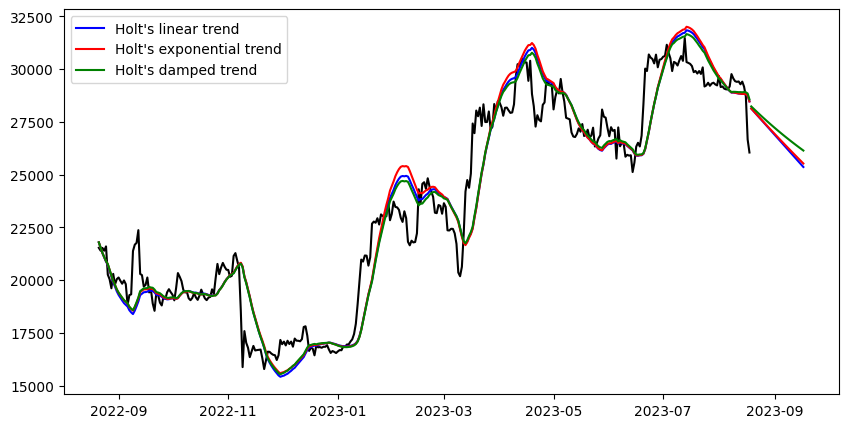

In [129]:
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
holt_1=Holt(bitcoin_data,
                     initialization_method='heuristic').fit(smoothing_level=0.1,
                                                            smoothing_trend=0.1,
optimized=False)
H_forecast1= holt_1.forecast(30).rename("Holt's linear trend")
holt_2=Holt(bitcoin_data, exponential=True,
                     initialization_method='heuristic').fit(smoothing_level=0.1,
                                                            smoothing_trend=0.1,
optimized=False)
H_forecast2= holt_2.forecast(30).rename("Holt's exponential trend")
holt_3=Holt(bitcoin_data, damped_trend=True,
                     initialization_method='heuristic').fit(smoothing_level=0.1,
                                                            smoothing_trend=0.1)
H_forecast3= holt_3.forecast(30).rename("Holt's damped trend")
plt.figure(figsize=(10,5))
plt.plot(bitcoin_data, color='black')
plt.plot(holt_1.fittedvalues, color='blue')
(line1,) = plt.plot(H_forecast1,color='blue')
plt.plot(holt_2.fittedvalues, color='red')
(line2,) = plt.plot(H_forecast2,color='red')
plt.plot(holt_3.fittedvalues, color='green')
(line3,) = plt.plot(H_forecast3,color='green')
plt.legend([line1,line2,line3],[H_forecast1.name,H_forecast2.name,H_forecast3.name])
print('RMSE linear model',np.sqrt(((holt_1.resid)**2). mean()))
print('RMSE exponential model',np.sqrt(((holt_2. resid)**2).mean()))
print('RMSE damped model',np.sqrt(((holt_3.resid)**2). mean()))

## ETS Model

Lastly, we will try an ETS model with an additive damped trend and let the algorithm estimate the parameters 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  8.56853D+00    |proj g|=  8.99900D-01

At iterate    1    f=  7.79002D+00    |proj g|=  1.23181D-01

At iterate    2    f=  7.78498D+00    |proj g|=  7.02062D-02

At iterate    3    f=  7.78249D+00    |proj g|=  1.31566D-02

At iterate    4    f=  7.78238D+00    |proj g|=  9.78391D-03

At iterate    5    f=  7.78212D+00    |proj g|=  4.36469D-03

At iterate    6    f=  7.78211D+00    |proj g|=  5.04841D-04

At iterate    7    f=  7.78211D+00    |proj g|=  2.84217D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


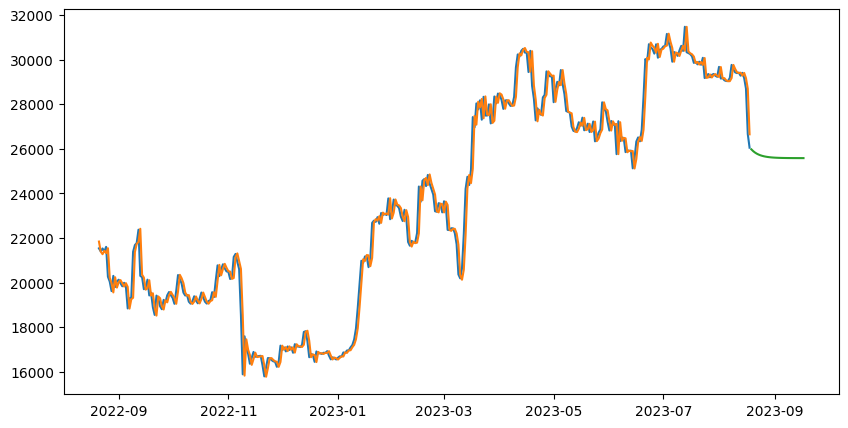

In [130]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

ets = ETSModel(bitcoin_data['Price'],
               trend='add',
               damped_trend=True,
               initialization_method='estimated').fit()

ets_pred=ets.forecast(30)
plt.figure(figsize=(10,5))
plt.plot(bitcoin_data)
plt.plot(ets.fittedvalues)
plt.plot(ets_pred)

ETS model performed the best among all the models considering RMSE which we can see in the last code chunk, and from the chart we saw earlier predicts the price to continue the downward trend and settles around the value of 25500 in the next 30 days.

In [131]:
print(ets_pred)


2023-08-19    25974.955396
2023-08-20    25896.304966
2023-08-21    25833.384622
2023-08-22    25783.048346
2023-08-23    25742.779326
2023-08-24    25710.564110
2023-08-25    25684.791937
2023-08-26    25664.174198
2023-08-27    25647.680007
2023-08-28    25634.484655
2023-08-29    25623.928373
2023-08-30    25615.483347
2023-08-31    25608.727327
2023-09-01    25603.322510
2023-09-02    25598.998657
2023-09-03    25595.539575
2023-09-04    25592.772309
2023-09-05    25590.558496
2023-09-06    25588.787446
2023-09-07    25587.370605
2023-09-08    25586.237133
2023-09-09    25585.330355
2023-09-10    25584.604933
2023-09-11    25584.024596
2023-09-12    25583.560325
2023-09-13    25583.188909
2023-09-14    25582.891776
2023-09-15    25582.654070
2023-09-16    25582.463905
2023-09-17    25582.311773
Freq: D, Name: simulation, dtype: float64


In [132]:

print(ets.summary())

                                 ETS Results                                  
Dep. Variable:                  Price   No. Observations:                  363
Model:                      ETS(AAdN)   Log Likelihood               -2824.904
Date:                Mon, 21 Aug 2023   AIC                           5661.809
Time:                        14:25:17   BIC                           5685.175
Sample:                    08-21-2022   HQIC                          5671.097
                         - 08-18-2023   Scale                       336493.756
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9605        nan        nan        nan         nan         nan
smoothing_trend     0.0467        nan        nan        nan         nan         nan
damping_trend       0.8000      

In [133]:
print("RMSE for ETS Model: ", np.sqrt((ets.resid**2).mean()))

RMSE for ETS Model:  580.0808184515867


# Conclusion 

We saw that the ETS model performed best considering RMSE and predicted a more constant trend in the next 30 days but the first exponential smoothing method that we did we received a slightly higher RMSE from the model but the values of AIC, BIC and AICc were very lower than ETS model. then we choose the best model to be an exponential smoothing or Holt's damped trend model.